# Datasets, dataloaders, and transforms

Pytorch provides a bunch of useful utilities for handling data, so we're going to explore a bunch of them here.

In [39]:
import os

import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

Download the data:

In [22]:
%%! # run this in bash
wget -nv https://download.pytorch.org/tutorial/faces.zip
unzip -q faces.zip
rm faces.zip
tree -L 1

['2019-12-11 20:59:24 URL:https://download.pytorch.org/tutorial/faces.zip [5780252/5780252] -> "faces.zip" [1]',
 '.',
 '├── datasets_tutorial.ipynb',
 '├── datasets_tutorial.py',
 '├── faces',
 '└── README.md',
 '',
 '1 directory, 3 files']

There's a csv file with face landmark data:

In [27]:
!ls faces/*.csv

faces/face_landmarks.csv


In [33]:
landmarks_df = pd.read_csv("faces/face_landmarks.csv")
landmarks_df.head()

,image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x,part_2_y,part_3_x,part_3_y,part_4_x,...,part_63_x,part_63_y,part_64_x,part_64_y,part_65_x,part_65_y,part_66_x,part_66_y,part_67_x,part_67_y
0,0805personali01.jpg,27,83,27,98,29,113,33,127,39,...,93,136,100,141,93,135,89,135,84,134
1,1084239450_e76e00b7e7.jpg,70,236,71,257,75,278,82,299,90,...,148,311,179,308,149,312,137,314,128,312
2,10comm-decarlo.jpg,66,114,65,128,67,142,68,156,72,...,128,162,136,167,127,166,121,165,116,164
3,110276240_bec305da91.jpg,42,140,45,161,51,180,61,200,73,...,144,197,180,189,147,204,136,208,125,209
4,1198_0_861.jpg,138,392,141,427,145,464,152,501,166,...,293,507,331,511,294,516,279,518,265,516


Let's examine a single example:

In [36]:
n = 65
img_name = landmarks_df.iloc[n, 0]
landmarks = landmarks_df.iloc[n, 1:].values
landmarks = landmarks.astype(float).reshape(-1, 2)

print("Image name: ", img_name)
print("Landmarks shape: ", landmarks.shape)

Image name:  person-7.jpg
Landmarks shape:  (68, 2)


Define a simple helper function to show landmarks

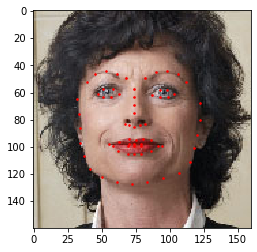

In [69]:
def show_landmarks(image, landmarks, ax=None):
    if ax:
        plt.sca(ax)
    plt.imshow(image)
    plt.scatter(*landmarks.T, color='red', s=10, marker='.')
    
show_landmarks(io.imread(f"faces/{img_name}"), landmarks)
plt.show()

## Datset class

The Dataset class is located at `torch.utils.data.Dataset`. It is an abstract class that provides `__len__` and `__getitem__` methods so that you can select the $i$th item.

In [55]:
class FaceLandmarksDataset(Dataset):
    """Face landmarks dataset."""
    def __init__(self, csv_file, rootdir, transform=None):
        """
        Args:
            csv_file [str]: file path of the csv file with all the data
            rootdir [str]: file path to the directory with all the images
            transform [callable, None]: optional transform to be applied to a
                sample
        """
        self.landmarks_df = pd.read_csv(csv_file)
        self.rootdir = rootdir
        self.transform = transform
        
    def __len__(self):
        return len(self.landmarks_df)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        if isinstance(idx, slice):
            raise ValueError("FaceLandmarkDataset does not support slicing")
            
        img_name = os.path.join(self.rootdir, self.landmarks_df.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_df.iloc[idx, 1:].values.astype(float).reshape(-1, 2)
        sample = {"image": image, "landmarks": landmarks}
        
        if self.transform:
            sample = self.transform(sample)
        return sample

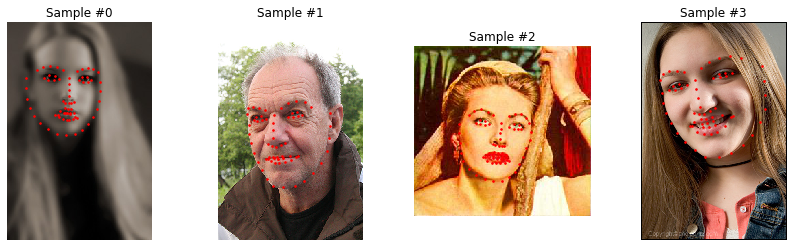

In [72]:
face_dataset = FaceLandmarksDataset("faces/face_landmarks.csv", "faces")

fig, axes = plt.subplots(ncols=4)
for i, ax in enumerate(axes):
    sample = face_dataset[i]
    plt.sca(ax)
    show_landmarks(**sample)
    ax.set_title(f"Sample #{i}")
    ax.axis("off")
plt.subplots_adjust(right=2)
plt.show()

## Transforms

Now we want to apply some transformations to the samples before they are passed to a neural network, like scaling, cropping, and converting to torch tensors.

In [77]:
class Rescale:
    """Rescale the image in a sample to a given size
    
    Args:
        output_size (tuple|int): desired output size
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
        
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
            
        new_h, new_w = map(int, (new_h, new_w))
        img = transform.resize(image, (new_h, new_w))
        landmarks = landmarks * [new_w / w, new_h / h]
        return {'image': img, 'landmarks': landmarks}
    
    
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

Now we can compose these transforms using torch and apply them to a sample

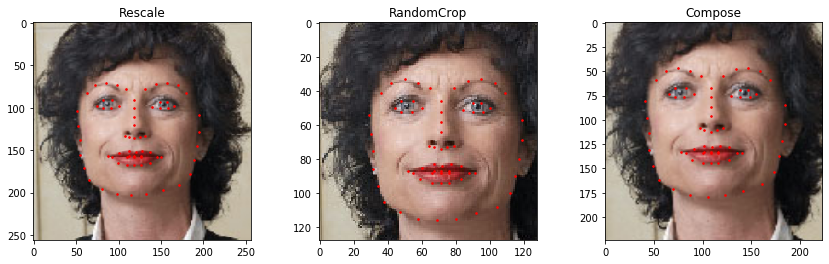

In [78]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256), RandomCrop(224)])

# apply each transform to a sample
sample = face_dataset[65]
fig, axes = plt.subplots(ncols=3)
for tsfrm, ax in zip([scale, crop, composed], axes):
    transformed_sample = tsfrm(sample)
    
    plt.sca(ax)
    show_landmarks(**transformed_sample)
    ax.set_title(type(tsfrm).__name__)
plt.subplots_adjust(right=2)
plt.show()

## Iterating through the dataset

Now we will put this all together to create a dataset with composed transforms.

In [79]:
transformed_dataset = FaceLandmarksDataset(
    csv_file="faces/face_landmarks.csv",
    rootdir="faces",
    transform=transforms.Compose([
        Rescale(256),
        RandomCrop(224),
        ToTensor()
    ])
)

In [81]:
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['landmarks'].size())

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


This is pretty nifty, but torch has a really cool class we can use to make it even cooler... the `DataLoader`! It can handle batching, shuffling, and loading the data in parallel!

0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


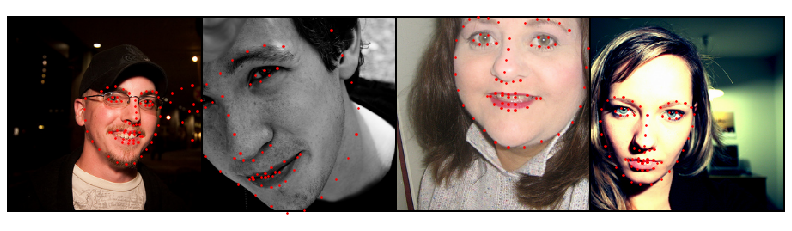

In [94]:
dataloader = DataLoader(
    transformed_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=4
)

# helper function to show a batch
def show_landmarks_batch(batch):
    images, landmarks = batch['image'], batch['landmarks']
    batch_size = len(images)
    im_size = images.size(2)
    grid_border_size = 2
    
    grid = utils.make_grid(images)
    plt.imshow(grid.numpy().transpose(1, 2, 0))
    
    for i in range(batch_size):
        x = landmarks[i,:,0].numpy() + i*im_size + (i+1)*grid_border_size
        y = landmarks[i,:,1].numpy() + grid_border_size
        plt.scatter(x, y, s=10, marker='.', c='red')

for i, batch in enumerate(dataloader):
    print(i, batch['image'].size(), batch['landmarks'].size())
    if i == 3:
        show_landmarks_batch(batch)
        plt.axis('off')
        plt.subplots_adjust(right=2)
        plt.show()
        break